<a href="https://colab.research.google.com/github/gguex/ISH_ressources_cours_ML/blob/main/TP03_modeles_linaires_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP 3:  modèles linéaires pour la classification

Dans ce troisième TP, nous allons faire des régressions linéaires et logistiques pour de la classification. Il y aura deux parties :

* La régression linéaire et logistique pour une variable binaire
* La régression linéaire et logistique pour une variable multimodale

Un exercice consitera à refaire ces modèles, afin d'optimiser cette fois la mesure F1, sur un nouveau jeu de données.

Les librairies et modules nécessaires sont

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Pour modifier la taille de sortie de graphiques dans le notebook
plt.rcParams['figure.figsize'] = [20, 10]
# Les modèles de régression
from sklearn.linear_model import LinearRegression, LogisticRegression
# Pour la CV
from sklearn.model_selection import train_test_split, GridSearchCV
# Nos différentes mesures
from sklearn.metrics import make_scorer, accuracy_score, \
  precision_score, recall_score
# Pour encoder les sorties en vecteurs one-hot
from sklearn.preprocessing import OneHotEncoder

---

## 1. Variable binaire

Nous allons utiliser ici le jeu de données "BreastCancer.csv" (https://www.rdocumentation.org/packages/mlbench/versions/2.1-3/topics/BreastCancer) possédant une variable "Class" indiquant si la tumeur prélevée est bénigne ou maligne. Les autres variables sont numériques.

On commence par charger le jeu de données

In [2]:
file_path = "drive/MyDrive/Colab Notebooks/ml_data/TP3/BreastCancer.csv"
data = pd.read_csv(file_path)
data

,Id,Cl.thickness,Cell.size,Cell.shape,Marg.adhesion,Epith.c.size,Bare.nuclei,Bl.cromatin,Normal.nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,benign
1,1002945,5,4,4,5,7,10,3,2,1,benign
2,1015425,3,1,1,1,2,2,3,1,1,benign
3,1016277,6,8,8,1,3,4,3,7,1,benign
4,1017023,4,1,1,3,2,1,3,1,1,benign
...,...,...,...,...,...,...,...,...,...,...,...
678,776715,3,1,1,1,3,2,1,1,1,benign
679,841769,2,1,1,1,2,1,1,1,1,benign
680,888820,5,10,10,3,7,3,8,10,2,malignant
681,897471,4,8,6,4,3,4,10,6,1,malignant


On isole nos entrées et sorties, et on transforme ces dernières en un vecteur binaire avec "benign" = 0 et "malignant" = 1.

In [3]:
inputs = data.drop(["Id", "Class"], axis=1)
outputs = (data["Class"].to_numpy() == "malignant")*1
outputs

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1,

On va maintenant séparer notre jeu de données en jeu d'entrainement/validation et test, avec l'option `stratify=outputs`, c'est-à-dire qu'on prend garde à ce que les classes contenues dans le vecteur `outputs` soient réparties de manière similaire dans les deux jeux de données.

In [4]:
inputs_train_val, inputs_test, outputs_train_val, outputs_test \
  = train_test_split(inputs, outputs, test_size=0.2, stratify=outputs)
# On observe les proportions
print(f"Proportion de malignant dans train_val : "
      f"{np.sum(outputs_train_val) / len(outputs_train_val):.2%}")
print(f"Proportion de malignant dans test : "
      f"{np.sum(outputs_test) / len(outputs_test):.2%}")

Proportion de malignant dans train_val : 34.98%
Proportion de malignant dans test : 35.04%


On va maintenant entrainer un modèle linéaire sur le jeu d'entrainement/validation

In [5]:
linear_reg = LinearRegression()
linear_reg.fit(inputs_train_val, outputs_train_val)

LinearRegression()

Les prédictions $\widehat{y}_i = 1$ s'obtiennent ssi $\widehat{z}_i > 5$. On calcul ensuite l'exactitude, la précision et le rappel, pour les jeux d'entrainement et de test

In [6]:
# Les prédictions
outputs_lin_train = (linear_reg.predict(inputs_train_val) > 0.5)*1
outputs_lin_test = (linear_reg.predict(inputs_test) > 0.5)*1
# Les scores
accuracy_lin_train = np.mean(outputs_train_val == outputs_lin_train)
accuracy_lin_test = np.mean(outputs_test == outputs_lin_test)
precision_lin_train = precision_score(outputs_train_val, outputs_lin_train)
precision_lin_test = precision_score(outputs_test, outputs_lin_test)
recall_lin_train = recall_score(outputs_train_val, outputs_lin_train)
recall_lin_test = recall_score(outputs_test, outputs_lin_test)

La régression logistique sera régularisée avec un hyperparamètre $\lambda \in [0.001, 0.5]$. On effectue donc une `GridSearchCV`, mais en observant nos trois mesures (`refit`, qui permet d'entrainer automatiquement le meilleur modèle, doit être mis selon une de ces mesures ou sur `False`)

In [7]:
# Paramètres pour la CV
params = np.linspace(0.001, 0.5, 50)
param_dict = {"C": params}
k = 5
# Recherche sur grille avec CV
logistic_reg = LogisticRegression()
gride_search = GridSearchCV(logistic_reg,
                            param_dict,
                            cv=k,
                            scoring=["accuracy", "precision", "recall"],
                            refit="recall")
gride_search.fit(inputs_train_val, outputs_train_val)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([0.001     , 0.01118367, 0.02136735, 0.03155102, 0.04173469,
       0.05191837, 0.06210204, 0.07228571, 0.08246939, 0.09265306,
       0.10283673, 0.11302041, 0.12320408, 0.13338776, 0.14357143,
       0.1537551 , 0.16393878, 0.17412245, 0.18430612, 0.1944898 ,
       0.20467347, 0.21485714, 0.22504082, 0.23522449, 0.24540816,
       0.25559184, 0.26577551, 0.27595918, 0.28614286, 0.29632653,
       0.3065102 , 0.31669388, 0.32687755, 0.33706122, 0.3472449 ,
       0.35742857, 0.36761224, 0.37779592, 0.38797959, 0.39816327,
       0.40834694, 0.41853061, 0.42871429, 0.43889796, 0.44908163,
       0.45926531, 0.46944898, 0.47963265, 0.48981633, 0.5       ])},
             refit='recall', scoring=['accuracy', 'precision', 'recall'])

On va faire le graphique de ces scores en fonction de $\lambda$

[]

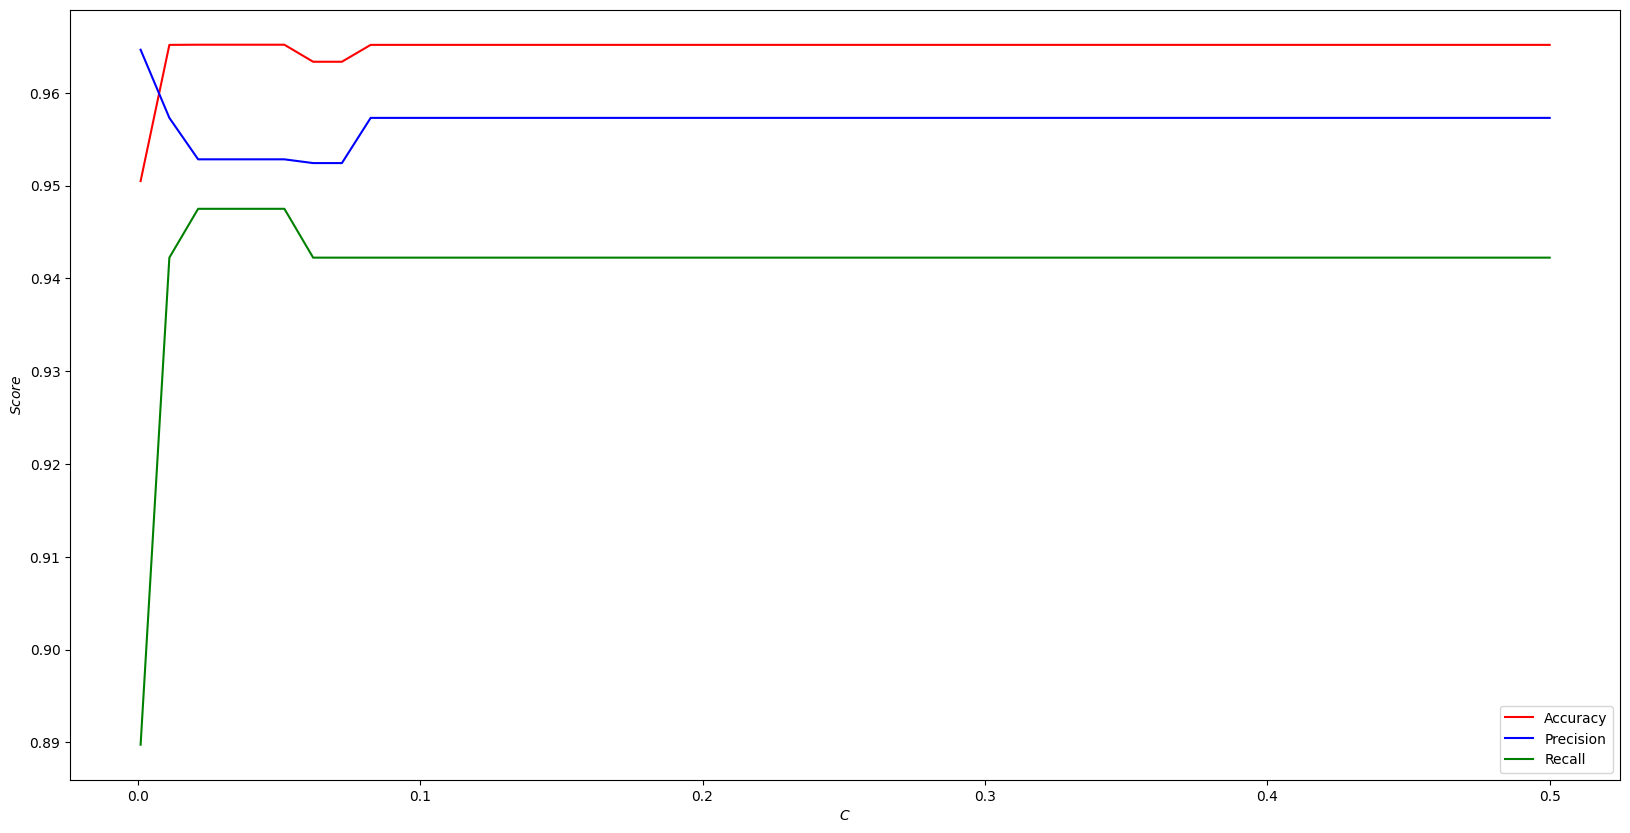

In [8]:
# Plot des scores
accuracy_scores = gride_search.cv_results_["mean_test_accuracy"]
precision_scores = gride_search.cv_results_["mean_test_precision"]
recall_scores = gride_search.cv_results_["mean_test_recall"]
# Plot des scores
fig, ax = plt.subplots()
ax.plot(params, accuracy_scores, c="red", label="Accuracy")
ax.plot(params, precision_scores, c="blue", label="Precision")
ax.plot(params, recall_scores, c="green", label="Recall")
ax.set_xlabel("$C$")
ax.set_ylabel("$Score$")
ax.legend()
plt.plot()

Sélectionnons le meilleur hyparamètre selon le rappel, puis entrainons ce modèle sur tout notre jeu d'entrainement/validation

In [9]:
# Les meilleurs modèles selon le recall
index_best_recall = np.where(recall_scores == max(recall_scores))[0][0]
best_recall_par = params[index_best_recall]
best_recall_log_reg = LogisticRegression(C=best_recall_par)
best_recall_log_reg.fit(inputs_train_val, outputs_train_val)

LogisticRegression(C=0.02136734693877551)

On calcule maintenant les différentes mesures selon ce modèle, sur le jeu d'entrainement/validation et test

In [10]:
# Les prédictions
outputs_log_train = best_recall_log_reg.predict(inputs_train_val)
outputs_log_test = best_recall_log_reg.predict(inputs_test)
# Les scores
accuracy_log_train = accuracy_score(outputs_train_val, outputs_log_train)
accuracy_log_test = accuracy_score(outputs_test, outputs_log_test)
precision_log_train = precision_score(outputs_train_val, outputs_log_train)
precision_log_test = precision_score(outputs_test, outputs_log_test)
recall_log_train = recall_score(outputs_train_val, outputs_log_train)
recall_log_test = recall_score(outputs_test, outputs_log_test)

Comparons les résultats entre notre modèle linéaire et le modèle logisitique retenu

In [11]:
print(f"L'exactitude pour le modèle linéaire est de "
f"{accuracy_lin_train:.2%} (train) {accuracy_lin_test:.2%} (test)")
print(f"La précision pour le modèle linéaire est de "
f"{precision_lin_train:.2%} (train) {precision_lin_test:.2%} (test)")
print(f"Le rappel pour le modèle linéaire est de "
f"{recall_lin_train:.2%} (train) {recall_lin_test:.2%} (test)")
print(f"L'exactitude pour le modèle logistique (C={best_recall_par:.4f}) est "
f"de {accuracy_log_train:.2%} (train) {accuracy_log_test:.2%} (test)")
print(f"La précision pour le modèle logistique (C={best_recall_par:.4f}) est "
f"de {precision_log_train:.2%} (train) {precision_log_test:.2%} (test)")
print(f"Le rappel pour le modèle logistique (C={best_recall_par:.4f}) est "
f"de {recall_log_train:.2%} (train) {recall_log_test:.2%} (test)")

L'exactitude pour le modèle linéaire est de 96.15% (train) 95.62% (test)
La précision pour le modèle linéaire est de 96.70% (train) 95.65% (test)
Le rappel pour le modèle linéaire est de 92.15% (train) 91.67% (test)
L'exactitude pour le modèle logistique (C=0.0214) est de 96.89% (train) 97.81% (test)
La précision pour le modèle logistique (C=0.0214) est de 96.28% (train) 95.92% (test)
Le rappel pour le modèle logistique (C=0.0214) est de 94.76% (train) 97.92% (test)


---

## 2. Multiples classes

La même procédure peut être effectuée sur un jeu de données contenant une variable avec de multiples classes, en l'occurence les Iris de Fisher, qui contient le type d'Iris dans "variety". On charge les données

In [12]:
file_path = "drive/MyDrive/Colab Notebooks/ml_data/TP3/iris.csv"
data = pd.read_csv(file_path)
inputs = data.drop(["variety"], axis=1)
outputs = data["variety"]

On va maintenant utiliser une instance de `OneHotEncoder()` pour recoder notre variable catégorielle en vecteurs one-hot. Notons que l'argument `categories_` continent l'ordre dans lequel le recodage a été effectué

In [13]:
encoder_1hot = OneHotEncoder()
outputs_1hot = encoder_1hot.fit_transform(
    outputs.to_numpy().reshape(-1, 1)
    ).toarray()
print(outputs_1hot[:10,:])
# Une array contenant les classes dans le bon ordre
classes = encoder_1hot.categories_[0]
print(classes)

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
['Setosa' 'Versicolor' 'Virginica']


Séparons en jeu d'entrainement/validation et test, tout en stratifiant selon `outputs`

In [14]:
inputs_train_val, inputs_test, outputs_train_val, outputs_test, \
outputs_1hot_train_val, outputs_1hot_test \
  = train_test_split(inputs, outputs, outputs_1hot, stratify=outputs)

La fonction ci-dessous nous permettra d'entrainer autant de modèles linaires qu'il y a de classe dans notre matrice de vecteur one-hot. Chaque modèle va essayer de prédire un des vecteurs one-hot

In [15]:
def train_lin_models(inputs, outputs_1hot):
  # Pour contenir les modèles
  lin_models = []
  # Boucle sur le nombre de classes
  for j in range(outputs_1hot.shape[1]):
    # On fait la régression avec comme sortie la colonne j
    lin_reg = LinearRegression()
    lin_reg.fit(inputs, outputs_1hot[:, j])
    lin_models.append(lin_reg)
  # Retour du vecteur de modèles
  return lin_models

On utilise cette fonction pour entrainer tous nos modèles linaires

In [16]:
trained_lin_models = train_lin_models(inputs_train_val, outputs_1hot_train_val)

La fonction ci-dessous nous permet de prédire les classes en fonction des entrées et des différents modèles. La classe retenue correspond au numéro de la régression linéaire qui donne la plus grande sortie

In [17]:
def predict_class(lin_models, inputs):
  # Nombre d'individus dans les entrées
  n_indiv = inputs.shape[0]
  # Nombre de modèles linéaires
  n_model = len(trained_lin_models)
  # Boucle pour remplir les prédictions linéaire dans
  # une matrice de taille n_indiv x n_model
  pred_mat = np.zeros((n_indiv, n_model))
  for i in range(n_model):
    pred = lin_models[i].predict(inputs)
    pred_mat[:, i] = pred
  # Transformation en vecteur de groupe
  class_pred = np.argmax(pred_mat, axis=1)
  # Retour du vecteur de class
  return class_pred


On fait les prédictions sur les jeux d'entrainement/validation et test

In [18]:
outputs_num_lin_train = predict_class(trained_lin_models, inputs_train_val)
outputs_num_lin_test = predict_class(trained_lin_models, inputs_test)
outputs_lin_train = classes[outputs_num_lin_train]
outputs_lin_test = classes[outputs_num_lin_test]
print(outputs_lin_test)

['Virginica' 'Virginica' 'Versicolor' 'Setosa' 'Versicolor' 'Virginica'
 'Setosa' 'Setosa' 'Virginica' 'Virginica' 'Setosa' 'Setosa' 'Setosa'
 'Setosa' 'Setosa' 'Virginica' 'Versicolor' 'Virginica' 'Versicolor'
 'Virginica' 'Virginica' 'Virginica' 'Virginica' 'Virginica' 'Versicolor'
 'Versicolor' 'Virginica' 'Virginica' 'Setosa' 'Virginica' 'Setosa'
 'Setosa' 'Setosa' 'Setosa' 'Virginica' 'Virginica' 'Versicolor'
 'Versicolor']


On calcule maintenant l'exactitude et la précision

In [19]:
accuracy_lin_train = np.mean(outputs_train_val == outputs_lin_train)
accuracy_lin_test = np.mean(outputs_test == outputs_lin_test)
precision_lin_train = precision_score(outputs_train_val, outputs_lin_train,
                                      average="weighted")
precision_lin_test = precision_score(outputs_test, outputs_lin_test,
                                     average="weighted")

On va rafaire tout cela avec une régression logistique multinomiale régularisée avec $\lambda \in [0.001, 2]$. **Attention**, l'option `multi_class` doit être sur `"multinomial"` lors de l'instanciation de la classe `LogisticRegression`, afin de bien faire une régression avec la fonction *softmax*. On remarque ici que l'on doit créer un score personnalisé (qui s'appuie sur `precision_score`) afin de dire comment doit être calculé la précision avec des classes multiples (ici, l'option `average="weighted"` permet de faire la moyenne pondérée de la précision sur chaque classe).

In [20]:
# Paramètres pour la CV
params = np.linspace(0.001, 5, 50)
param_dict = {"C": params}
k = 5
# Fonction particulière pour le scoring :
# on fait la moyenne pondérée des précisions par classe, one-vs-rest
def my_precision(y_true, y_pred):
  return precision_score(y_true, y_pred, average="weighted")
# Pour ce modèle, on a du augmenter le nombre d'itérations
# dans la descente du gradient
logistic_reg = LogisticRegression(max_iter=10000, multi_class="multinomial")
# Recherche sur grille avec CV
grid_search = GridSearchCV(logistic_reg,
                           param_dict,
                           cv=k,
                           scoring={"accuracy": "accuracy",
                                    "precision": make_scorer(my_precision)},
                           refit=False,
                           error_score='raise')
grid_search.fit(inputs_train_val, outputs_train_val)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GridSearchCV(cv=5, error_score='raise',
             estimator=LogisticRegression(max_iter=10000,
                                          multi_class='multinomial'),
             param_grid={'C': array([1.00000000e-03, 1.03020408e-01, 2.05040816e-01, 3.07061224e-01,
       4.09081633e-01, 5.11102041e-01, 6.13122449e-01, 7.15142857e-01,
       8.17163265e-01, 9.19183673e-01, 1.02120408e+00, 1.12322449e+00,
       1.22524490e+00, 1.32726531e+00, 1.429285...
       3.26565306e+00, 3.36767347e+00, 3.46969388e+00, 3.57171429e+00,
       3.67373469e+00, 3.77575510e+00, 3.87777551e+00, 3.97979592e+00,
       4.08181633e+00, 4.18383673e+00, 4.28585714e+00, 4.38787755e+00,
       4.48989796e+00, 4.59191837e+00, 4.69393878e+00, 4.79595918e+00,
       4.89797959e+00, 5.00000000e+00])},
             refit=False,
             scoring={'accuracy': 'accuracy',
                      'precision': make_scorer(my_precision)})

On peut maintenant faire le graphique de nos mesures en fonction de $\lambda$

[]

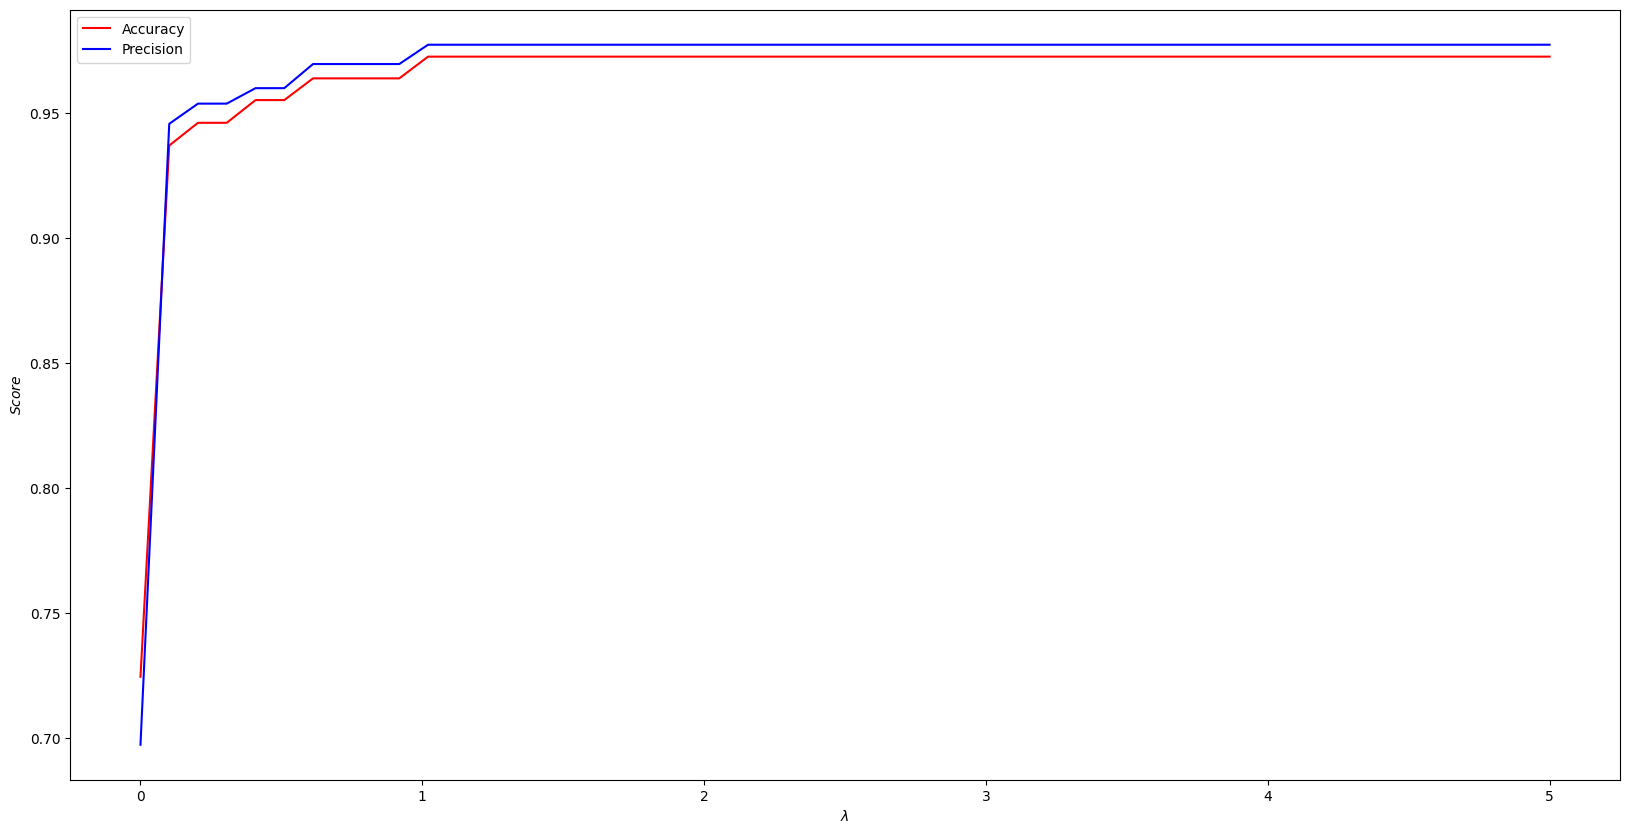

In [21]:
# Plot des scores
accuracy_scores = grid_search.cv_results_["mean_test_accuracy"]
precision_scores = grid_search.cv_results_["mean_test_precision"]
# Plot des scores
fig, ax = plt.subplots()
ax.plot(params, accuracy_scores, c="red", label="Accuracy")
ax.plot(params, precision_scores, c="blue", label="Precision")
ax.set_xlabel("$\lambda$")
ax.set_ylabel("$Score$")
ax.legend()
plt.plot()

On retient le meilleur modèle selon la précision

In [22]:
# Les meilleurs modèles selon la précision
index_best_precision = np.where(precision_scores == max(precision_scores))[0][0]
best_precision_par = params[index_best_precision]
best_precision_log_reg = LogisticRegression(max_iter=10000, C=best_precision_par)
best_precision_log_reg.fit(inputs_train_val, outputs_train_val)

LogisticRegression(C=1.0212040816326529, max_iter=10000)

On calcule les mesures

In [23]:
# Les prédictions
outputs_log_train = best_precision_log_reg.predict(inputs_train_val)
outputs_log_test = best_precision_log_reg.predict(inputs_test)
# Les scores
accuracy_log_train = accuracy_score(outputs_train_val, outputs_log_train)
accuracy_log_test = accuracy_score(outputs_test, outputs_log_test)
precision_log_train = my_precision(outputs_train_val, outputs_log_train)
precision_log_test = my_precision(outputs_test, outputs_log_test)

Et on compare à la régression linéaire

In [24]:
print(f"L'exactitude pour le modèle linéaire est de "
f"{accuracy_lin_train:.2%} (train) {accuracy_lin_test:.2%} (test)")
print(f"La précision pour le modèle linéaire est de "
f"{precision_lin_train:.2%} (train) {precision_lin_test:.2%} (test)")
print(f"L'exactitude pour le modèle logistique (C={best_recall_par:.4f}) est "
f"de {accuracy_log_train:.2%} (train) {accuracy_log_test:.2%} (test)")
print(f"La précision pour le modèle logistique (C={best_recall_par:.4f}) est "
f"de {precision_log_train:.2%} (train) {precision_log_test:.2%} (test)")

L'exactitude pour le modèle linéaire est de 86.61% (train) 81.58% (test)
La précision pour le modèle linéaire est de 87.30% (train) 84.58% (test)
L'exactitude pour le modèle logistique (C=0.0214) est de 97.32% (train) 97.37% (test)
La précision pour le modèle logistique (C=0.0214) est de 97.34% (train) 97.57% (test)


Finalement, on va afficher, à l'aide de `contourf`, les zones de décision de notre modèle. Il s'agit pour cela de créer des points d'une grille (définie sur les variables "petal.length" et "petal.width", les variables associées aux sépales seront maintenues constantes sur leur moyenne) puis d'estimer les prédictions de ces différents points. Remarquez que nous utilisons ici `predict_proba` qui premet d'obtenir les probabilités d'être dans chaque classe. Les `contourf` utilisent ensuite ces probabilités pour tracer les contours

[]

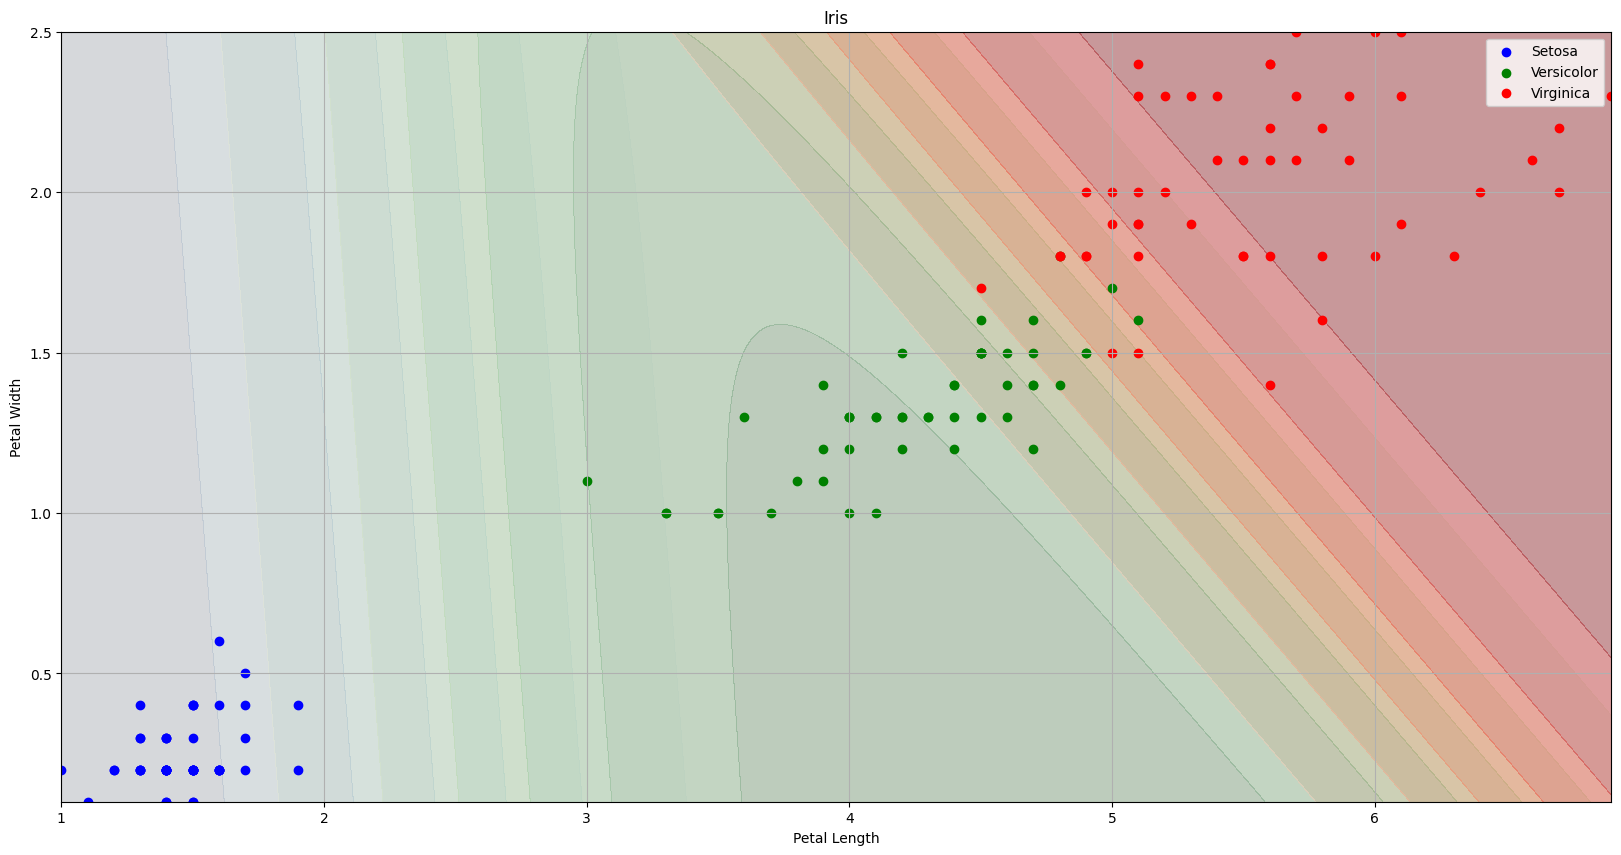

In [25]:
# On fait une grille
grid_size = 500
p_length_min = data["petal.length"].min()
p_length_max =  data["petal.length"].max()
p_width_min = data["petal.width"].min()
p_width_max =  data["petal.width"].max()
grid_x, grid_y = np.meshgrid(np.linspace(p_length_min, p_length_max, grid_size),
                             np.linspace(p_width_min, p_width_max, grid_size))

# On recrée un jeu de données avec les points de la grille
mean_sepal_length = data["sepal.length"].mean()
mean_sepal_width = data["sepal.width"].mean()
grid_data_mat = np.stack((np.repeat([mean_sepal_length], grid_size**2),
                          np.repeat([mean_sepal_width], grid_size**2),
                          grid_x.flatten(),
                          grid_y.flatten())).T
grid_data = pd.DataFrame(grid_data_mat, columns=inputs.columns)

# Les prédicions probabiliste sur la grille
grid_proba_pred = best_precision_log_reg.predict_proba(grid_data)

# Création d'un dictionnaire pour les couleurs
colors = {"Setosa": "blue", "Versicolor": "green", "Virginica": "red"}

# Création des objets servant à l'affichage graphique
fig, ax = plt.subplots()

# On ajoute notre contour
pred_0 = grid_proba_pred[:, 0].reshape(grid_x.shape)
pred_1 = grid_proba_pred[:, 1].reshape(grid_x.shape)
pred_2 = grid_proba_pred[:, 2].reshape(grid_x.shape)
ax.contourf(grid_x, grid_y, pred_0, cmap="Blues", alpha=0.4)
ax.contourf(grid_x, grid_y, pred_1, cmap="Greens", alpha=0.4)
ax.contourf(grid_x, grid_y, pred_2, cmap="Reds", alpha=0.4)

# On fait une boucle sur les espèces
for species in data["variety"].unique():

  # Selection de l'espèce
  species_df = data[data["variety"] == species]

  # Scatter plot de l'espèce
  ax.scatter(x=species_df["petal.length"],
            y=species_df["petal.width"],
            c=colors[species],
            label=species)

# Ajout du nom des axes, d'un titre, d'une légende, et d'une grille
ax.set_xlabel("Petal Length")
ax.set_ylabel("Petal Width")
ax.set_title("Iris")
ax.legend()
ax.grid(True)

plt.plot()

## Exercice

Dans cet exercice, vous allez effectuer la même procédure que dans les exemples précédents, mais sur le jeu de données "PimaIndiansDiabetes.csv" (plus d'info https://www.rdocumentation.org/packages/mlbench/versions/2.1-3/topics/PimaIndiansDiabetes) et pour optimiser la mesure F1 (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html).

* La variable dépendante est "diabetes", qui peut être "pos" ou "neg". Toutes les autres variables sont numériques.
* Il s'agira de faire une régression linaire et une régression logistique régularisée. À vous de trouver l'intervalle des hyparamètres à tester.
* La mesure à optimiser est la mesure F1, qui peut être calculée avec `sklearn.metrics.f1_score`.

Bonne chance !